In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab
import mysql.connector as sql
import geopandas as gpd
from shapely.geometry import Point
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_extraction import FeatureHasher
from sklearn.pipeline import Pipeline
from feature_engine.categorical_encoders import MeanCategoricalEncoder, OneHotCategoricalEncoder
from feature_engine import missing_data_imputers as mdi
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import xgboost as xgb
from xgboost import plot_tree
import details


import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.5f}'.format

In [2]:
#Use this code to store the best_params so that you don't have to rerun the hyperoptimization function
import pickle

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

### Import the data using mysql database

In [20]:
#Load the data from mysql
password = details.db_password
db_connection = sql.connect(host='Samuels-MacBook-Air.local', 
                            database='realestate_AVM',
                            user='root',
                            password=password)


In [21]:
homes = pd.read_sql('SELECT * FROM Homes;', con=db_connection)
history = pd.read_sql('SELECT * FROM SalesHistory;', con=db_connection)

In [22]:
#Lets combine the two dataframes
print(homes.shape, history.shape)
df = pd.merge(homes, history, on='ParcelNumber', how='left')
print(df.shape)

(8903, 18) (18906, 3)
(21787, 20)


In [23]:
#This portion is just a spot check of our ETL process
#We'll be keeping the values from the right dataframe(for columns date and sale_price) since they exist in both dataframes
#There are a lot of null values for properties that are not in the saleshistory. We'll fill those missing values 
#with the values from the left dataframe and then drop the duplicate features from the left dataframe

print(f'Number of missing values for price after the merge and before the imputation: {df.SalePrice_y.isnull().sum()}')
missing = df.loc[df['SalePrice_y'].isnull()].index
df['Date_y'] = df['Date_y'].fillna(df['Date_x'])
df['SalePrice_y'] = df['SalePrice_y'].fillna(df['SalePrice_x'])

df.drop(['Date_x', 'SalePrice_x'], axis=1, inplace=True)
df.rename(columns={'Date_y': 'Date', 'SalePrice_y':'SalePrice'}, inplace=True)

print(f'Number of missing values for price after imputing the missing values: {df.SalePrice.isnull().sum()}')
df.head()

Number of missing values for price after the merge and before the imputation: 2881
Number of missing values for price after imputing the missing values: 0


,ParcelNumber,Address,Latitude,Longitude,HomeSize,LotSize,YearBuilt,Age,SexOffenders,CrimeIndex,EnviornmentalHazards,SchoolQuality,Bedrooms,Bathrooms,Neighborhood,SalePriceTransformed,Date,SalePrice
0,2004006017,8380 Kentland Ave,34.22212,-118.61781,1882.00000,9072.00000,1972,48,4,Very Low,4,Average,4,2,West Hills,923.31900,2020-11-23,850000.00000
1,2004006017,8380 Kentland Ave,34.22212,-118.61781,1882.00000,9072.00000,1972,48,4,Very Low,4,Average,4,2,West Hills,923.31900,2006-11-03,680000.00000
2,2004009012,8356 Sausalito Ave,34.22127,-118.61559,1477.00000,11377.00000,1960,60,5,Very Low,4,Average,3,2,West Hills,882.69400,2020-09-23,777000.00000
3,2004011011,22546 Malden St,34.22459,-118.61834,3422.00000,9972.00000,1973,47,4,Very Low,4,Average,7,5,West Hills,998.66800,2020-10-02,995000.00000
4,2004015018,22711 Michale St,34.22703,-118.62186,2080.00000,11248.00000,1959,61,4,Very Low,5,Average,3,3,West Hills,925.39800,2020-09-28,854000.00000


In [24]:
#Get rid of features that won't be used in the model
dropped_features = ['ParcelNumber', 'Address', 'Date']
df = df.drop(dropped_features, axis=1)

In [25]:
#Turn the dataframe into a geodataframe
gdf = gpd.GeoDataFrame(df, geometry=[Point(xy) for xy in zip(df.Longitude, df.Latitude)])
gdf.crs = {'init': 'epsg:4326'}

In [26]:
#Split the dataset into train and test set
x_train, x_test, y_train, y_test = train_test_split(gdf.drop(['SalePrice', 'SalePriceTransformed'], axis=1), gdf['SalePriceTransformed'], test_size=.1, random_state=24)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=.2, random_state=24)

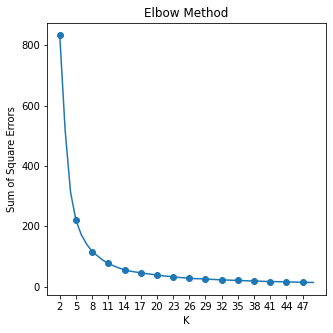

In [10]:
#Cluster the properties by location
ssd = []

for i in range(2,50):
    
    kmeans = KMeans(n_clusters=i, init ='k-means++')
    kmeans.fit_predict(x_train[['Latitude', 'Longitude']])
    ssd.append(ssd.append(kmeans.inertia_))
    
ssd = ssd[::2]


#Elbow method to determine the optimal number for k
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(list(range(2,50)), ssd, marker='o', markevery=3)
plt.title('Elbow Method')
plt.xlabel('K')
plt.ylabel('Sum of Square Errors')
ax.set(xticks=range(2,50,3));

In [27]:
#9 seems like the optimal number of clusters
kmeans = KMeans(n_clusters=9, init='k-means++')
x_train['geolocation_cluster'] = kmeans.fit_predict(x_train[['Latitude', 'Longitude']])
x_val['geolocation_cluster'] = kmeans.predict(x_val[['Latitude', 'Longitude']])
x_test['geolocation_cluster'] = kmeans.predict(x_test[['Latitude', 'Longitude']])

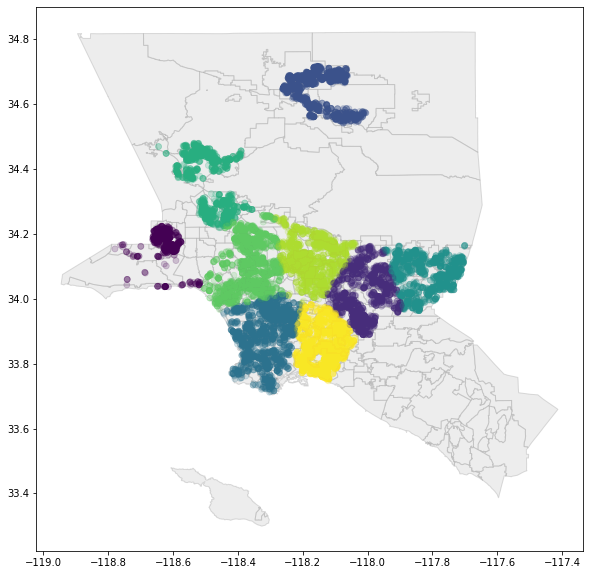

In [11]:
#Plot the data point on a map of Los Angeles
fig, ax = plt.subplots(figsize=(10,10))

la_full = gpd.read_file('LACounty/l.a. county neighborhood (v6).shp')
la_full.plot(ax=ax, alpha=0.4, edgecolor='darkgrey', color='lightgrey', aspect=1,zorder=1)

#Conver x_train df into geopandas df so that we can visualize it
temp_plot = gpd.GeoDataFrame(x_train.copy(), geometry=[Point(xy) for xy in zip(x_train.Longitude, x_train.Latitude)])
temp_plot.plot(ax=ax, aspect=1, c=temp_plot['geolocation_cluster'], alpha=0.2, linewidth=0.8, zorder=2);
plt.savefig('Images/clusters.png')

In [28]:
#Find the distance between each point and each observation in order to smooth out prices that lie on the border of clusters
kc = kmeans.cluster_centers_

#Create a function that will calculate the distances between each cluster center
def calculate_distances(df, kc):
    for i in range(len(kc)):
        df['distance_' + str(i)] = np.sqrt((df.Latitude -
                                            kc[i][0])**2 + (df.Longitude - kc[i][1])**2)
    return df
    
x_train = calculate_distances(x_train, kc)
x_val = calculate_distances(x_val, kc)
x_test = calculate_distances(x_test, kc)

#Save the kmeans object
save_obj(kmeans, 'kmeans_neighborhood')
    
#Drop the latitude and longitude
x_train.drop(['Latitude', 'Longitude', 'geolocation_cluster', 'geometry'], axis=1, inplace=True)
x_val.drop(['Latitude', 'Longitude', 'geolocation_cluster', 'geometry'], axis=1, inplace=True)
x_test.drop(['Latitude', 'Longitude', 'geolocation_cluster', 'geometry'], axis=1, inplace=True)

In [29]:
#Dummy encode the categorical variables
ohe_encoder = OneHotCategoricalEncoder(variables=['CrimeIndex', 'SchoolQuality'])

ohe_encoder.fit(x_train)

x_train = ohe_encoder.transform(x_train)
x_val = ohe_encoder.transform(x_val)
x_test = ohe_encoder.transform(x_test)

In [30]:
#Use mean target encoding on the neighborhood feature
mean_enc = MeanCategoricalEncoder(variables=['Neighborhood'])

mean_enc.fit(x_train, y_train)
                                             
x_train = mean_enc.transform(x_train)
x_val = mean_enc.transform(x_val)
x_test = mean_enc.transform(x_test)
x_test['Neighborhood'].fillna(x_train.Neighborhood.mean(), inplace=True)

In [31]:
x_train.columns

Index(['HomeSize', 'LotSize', 'YearBuilt', 'Age', 'SexOffenders',
       'EnviornmentalHazards', 'Bedrooms', 'Bathrooms', 'Neighborhood',
       'distance_0', 'distance_1', 'distance_2', 'distance_3', 'distance_4',
       'distance_5', 'distance_6', 'distance_7', 'distance_8',
       'CrimeIndex_Moderate', 'CrimeIndex_Low', 'CrimeIndex_Slightly High',
       'CrimeIndex_Very Low', 'CrimeIndex_High', 'CrimeIndex_Moderately High',
       'CrimeIndex_Very High', 'SchoolQuality_Poor',
       'SchoolQuality_Above Average', 'SchoolQuality_Average',
       'SchoolQuality_Excellent'],
      dtype='object')

In [ ]:
#Rename the column names in order to prepare it for the application
column_name_mapper = {
                      'Latitude':'latitude',
                      'Longitude':'longitude',
                      'HomeSize':'home_size',
                      'LotSize':'lot_size',
                      'YearBuilt':'year_built',
                      'Age':'age',
                      'Bedrooms':'bedrooms',
                      'Bathrooms':'bathrooms',
                      'SexOffenders':'sex_offenders',
                      'EnviornmentalHazards': 'enviornmental_hazards',
                      'SchoolQuality':'school_quality',
                      'Neighborhood':'neighborhood',
                      'CrimeIndex':'crime_index',
                      'SalePrice':'sale_price',
                      'SalePriceTransformed': 'sale_price_transformed'
                    
                      }

### XGBoost Model

In [44]:
#Optimize the objective function with hyperopt for xgboost


#Write a function that calculates mape
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Definte the search space
space = {
            'base_score' : [.5, .15, .25, .5, .75, .85, .95, .975, .9825, .999],
            'booster' : ['gbtree', 'dart'],
            'importance_type' : ['weight', 'gain', 'cover', 'total_gain', 'total_cover'],
            'learning_rate' : [None, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4],
            #'max_delta_step' : [None, 1, 2, 3, 4, 5,10,15,20,25,30,35,40,45,50,55,60],
            'num_parallel_tree' : [None, 1, 2, 3, 4, 5],
    
         }

#Objective function
#cv = KFold(n_splits=8, random_state=24, shuffle=True)

def acc_model(params):
    
    depth = int(params['max_depth'])
    est= int(params['n_estimators'])
   
    regressor = xgb.XGBRegressor(random_state=24,
                                 base_score= params['base_score'],
                                 booster= params['booster'], 
                                 colsample_bylevel= params['colsample_bylevel'], 
                                 colsample_bynode= params['colsample_bynode'],
                                 colsample_bytree= params['colsample_bytree'], 
                                 gamma= params['gamma'], 
                                 importance_type= params['importance_type'],
                                 learning_rate= params['learning_rate'],
                                 #max_delta_step= params['max_delta_step'], 
                                 max_depth= depth, 
                                 min_child_weight= params['min_child_weight'],
                                 n_estimators=est, 
                                 num_parallel_tree= params['num_parallel_tree'], 
                                 reg_lambda= params['reg_lambda'])
   
    regressor.fit(x_train, y_train)
    
    val_predictions = regressor.predict(x_val)**2
    y_val_transformed = y_val**2
    
    return mean_absolute_percentage_error(y_val_transformed, val_predictions)
    #return -cross_val_score(regressor, x_train, y_train, scoring='neg_mean_absolute_error').mean()

#Define the search space
param_space = { 
                'base_score' : hp.choice('base_score', space.get('base_score')),
                'booster': hp.choice('booster', space.get('booster')),
                'colsample_bylevel': hp.uniform('colsample_bylevel', 0, 1),
                'colsample_bynode': hp.uniform('colsample_bynode', 0, 1),
                'colsample_bytree': hp.uniform('colsample_bytree', 0, 1),
                'gamma': hp.uniform('gamma',1,15),
                'importance_type': hp.choice('importance_type', space.get('importance_type')),
                'learning_rate': hp.choice('learning_rate', space.get('learning_rate')),
                #'max_delta_step': hp.quniform('n_estimators', 25,1000,1),
                'max_depth': hp.quniform('max_depth',1,10,1),
                'min_child_weight': hp.uniform('min_child_weight', 1, 100),
                'n_estimators': hp.quniform('n_estimators', 25,1000,1),
                'num_parallel_tree': hp.choice('num_parallel_tree', space.get('num_parallel_tree')),
                'reg_lambda': hp.uniform('reg_lambda',1,15)
            }

best = 1000

def f(params):
    global best
    acc = acc_model(params)
    if acc < best:
        best = acc
        print ('new best:', best, params) 
        
    return {'loss': acc, 'status': STATUS_OK}

trials = Trials()
best_params = fmin(f, param_space, algo=tpe.suggest, max_evals=25, trials=trials)
print ('best:')
print (best_params)

new best:                                             
9.579711465873192                                     
{'base_score': 0.95, 'booster': 'gbtree', 'colsample_bylevel': 0.025654664392714577, 'colsample_bynode': 0.868827645867332, 'colsample_bytree': 0.8796934700786718, 'gamma': 3.635486343354909, 'importance_type': 'total_cover', 'learning_rate': 0.35, 'max_depth': 9.0, 'min_child_weight': 52.97680901732657, 'n_estimators': 832.0, 'num_parallel_tree': 4, 'reg_lambda': 8.50959166140263}
new best:                                                                      
7.861540413764185                                                              
{'base_score': 0.999, 'booster': 'gbtree', 'colsample_bylevel': 0.8360427133426364, 'colsample_bynode': 0.2870607543487723, 'colsample_bytree': 0.38170923666025536, 'gamma': 2.2852553797276656, 'importance_type': 'total_cover', 'learning_rate': 0.2, 'max_depth': 9.0, 'min_child_weight': 35.8490206347785, 'n_estimators': 875.0, 'num_parallel_tr

In [45]:
#Create a function that can transform the parameters into a readable object for the XGBRegressor
def return_proper_params(best):
    temp = best.copy()
    temp['max_depth'] = int(temp['max_depth'])
    temp['n_estimators'] = int(temp['n_estimators'])
    
    for param in space:
        temp[param] = space.get(param)[best.get(param)]
        
    return temp


best_params = return_proper_params(best_params)
best_params

{'base_score': 0.975,
 'booster': 'gbtree',
 'colsample_bylevel': 0.4045646260107985,
 'colsample_bynode': 0.608619469466224,
 'colsample_bytree': 0.5119601641725785,
 'gamma': 6.734973904839098,
 'importance_type': 'total_gain',
 'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 14.55450666270957,
 'n_estimators': 996,
 'num_parallel_tree': 5,
 'reg_lambda': 3.2731100944585503}

In [15]:
#save_obj(best_params, 'best_params_xgb')
best_params = load_obj('best_params_xgb')
best_params

{'base_score': 0.975,
 'booster': 'gbtree',
 'colsample_bylevel': 0.4045646260107985,
 'colsample_bynode': 0.608619469466224,
 'colsample_bytree': 0.5119601641725785,
 'gamma': 6.734973904839098,
 'importance_type': 'total_gain',
 'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 14.55450666270957,
 'n_estimators': 996,
 'num_parallel_tree': 5,
 'reg_lambda': 3.2731100944585503}

In [16]:
#Write a function that calculates mape
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


regressor = xgb.XGBRegressor(random_state=24,
                             base_score= best_params['base_score'],
                             booster= best_params['booster'],
                             colsample_bylevel= best_params['colsample_bylevel'], 
                             colsample_bynode= best_params['colsample_bynode'],
                             colsample_bytree= best_params['colsample_bytree'],
                             gamma= best_params['gamma'],
                             importance_type= best_params['importance_type'],
                             learning_rate= best_params['learning_rate'],
                             #max_delta_step= 50,#best_params['max_delta_step']) 
                             max_depth= best_params['max_depth'],
                             min_child_weight= best_params['min_child_weight'],
                             n_estimators= best_params['n_estimators'], 
                             num_parallel_tree= best_params['num_parallel_tree'], 
                             reg_lambda= best_params['reg_lambda'])

regressor.fit(x_train, y_train)

# Need to back transform the target variable
test_predictions = regressor.predict(x_test)**2
y_test_transformed = y_test**2


score = np.round(mean_absolute_percentage_error(y_test_transformed, test_predictions),3)
print(f'XGBoost mape on testing set: {score}%')

XGBoost mape on testing set: 6.426%


In [17]:
#MAPE for the train set
train_predictions = regressor.predict(x_train)**2
y_train_transformed = y_train**2

score = np.round(mean_absolute_percentage_error(y_train_transformed, train_predictions),3)
print(f'XGBoost mape on training set: {score}%')

XGBoost mape on training set: 1.88%


In [18]:
x_train.head(2)

,HomeSize,LotSize,YearBuilt,Age,SexOffenders,EnviornmentalHazards,Bedrooms,Bathrooms,Neighborhood,distance_0,distance_1,distance_2,distance_3,distance_4,distance_5,distance_6,distance_7,distance_8,CrimeIndex_Moderate,CrimeIndex_Low,CrimeIndex_Slightly High,CrimeIndex_Very Low,CrimeIndex_High,CrimeIndex_Moderately High,CrimeIndex_Very High,SchoolQuality_Poor,SchoolQuality_Above Average,SchoolQuality_Average,SchoolQuality_Excellent
4087,1014.00000,6092.00000,1953,67,1,5,3,1,607.37385,0.67470,0.57889,0.08106,0.73048,0.58210,0.45486,0.55524,0.46739,0.73034,1,0,0,0,0,0,0,1,0,0,0
1572,1818.00000,6000.00000,1940,80,3,12,3,2,969.97644,0.30399,0.34265,0.51142,0.27588,0.50925,0.26032,0.07833,0.15079,0.35661,0,1,0,0,0,0,0,0,1,0,0


In [19]:
x_train.columns

Index(['HomeSize', 'LotSize', 'YearBuilt', 'Age', 'SexOffenders',
       'EnviornmentalHazards', 'Bedrooms', 'Bathrooms', 'Neighborhood',
       'distance_0', 'distance_1', 'distance_2', 'distance_3', 'distance_4',
       'distance_5', 'distance_6', 'distance_7', 'distance_8',
       'CrimeIndex_Moderate', 'CrimeIndex_Low', 'CrimeIndex_Slightly High',
       'CrimeIndex_Very Low', 'CrimeIndex_High', 'CrimeIndex_Moderately High',
       'CrimeIndex_Very High', 'SchoolQuality_Poor',
       'SchoolQuality_Above Average', 'SchoolQuality_Average',
       'SchoolQuality_Excellent'],
      dtype='object')

In [49]:
#Save the model
#pickle.dump(regressor, open("xgb_model.pickle.dat", "wb"))
# load model from file
loaded_model = pickle.load(open("xgb_model.pickle.dat", "rb"))

In [50]:
# Test the loaded model
# load model from file
loaded_model = pickle.load(open("xgb_model.pickle.dat", "rb"))

test_predictions = loaded_model.predict(x_test)**2
y_test_transformed = y_test**2



score = np.round(mean_absolute_percentage_error(y_test_transformed, test_predictions),3)
print(f'XGBoost mape on testing set: {score}%')

XGBoost mape on testing set: 7.005%


In [52]:
#Let's examine the residuals
residuals = x_train.copy()
residuals[['Latitude', 'Longitude']] = gdf[['Latitude', 'Longitude']]
residuals['SalePriceTransformed'] = y_train_transformed
residuals['predicted_sale_price'] = train_predictions
residuals['residuals'] = y_train_transformed - train_predictions
sorted_df = residuals.sort_values(by='residuals', ascending=False)
sorted_df

,HomeSize,LotSize,YearBuilt,Age,SexOffenders,EnviornmentalHazards,Bedrooms,Bathrooms,Neighborhood,distance_0,distance_1,distance_2,distance_3,distance_4,distance_5,distance_6,distance_7,distance_8,CrimeIndex_Slightly High,CrimeIndex_Low,CrimeIndex_Moderate,CrimeIndex_High,CrimeIndex_Very Low,CrimeIndex_Moderately High,CrimeIndex_Very High,SchoolQuality_Average,SchoolQuality_Above Average,SchoolQuality_Poor,SchoolQuality_Excellent,Latitude,Longitude,SalePriceTransformed,predicted_sale_price,residuals
3479,2175.00000,6733.00000,1992,7,3,2,4,3,616.21259,0.54933,0.50312,0.57233,0.13934,0.73225,0.71684,0.45908,0.53542,0.71153,0,0,1,0,0,0,0,1,0,0,0,34.56462,-118.03095,1343257.82010,939969.68750,403288.13260
3666,1707.00000,11567.00000,1980,15,6,2,4,2,608.08608,0.53754,0.44810,0.52928,0.11411,0.69787,0.69463,0.42948,0.54443,0.65865,0,0,1,0,0,0,0,1,0,0,0,34.54822,-118.08386,1617348.06250,1242511.87500,374836.18750
17127,520.00000,6990.00000,1951,62,3,4,1,1,712.48427,0.06409,0.58219,0.37773,0.59108,0.37729,0.26560,0.19396,0.17070,0.64163,0,0,1,0,0,0,0,1,0,0,0,34.07502,-117.98674,1630090.56250,1372145.37500,257945.18750
9955,1954.00000,8365.00000,1956,64,1,2,3,2,972.87658,0.16656,0.46481,0.30360,0.47881,0.37446,0.32330,0.11306,0.27109,0.55266,0,0,1,0,0,0,0,1,0,0,0,34.17177,-118.06897,1603768.96000,1380562.75000,223206.21000
9445,1268.00000,7760.00000,1921,78,8,10,2,1,994.84645,0.26567,0.33944,0.11138,0.53440,0.23938,0.29096,0.08162,0.44111,0.36993,0,1,0,0,0,0,0,0,1,0,0,34.12142,-118.25462,1551718.66240,1334820.25000,216898.41240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5791,1734.00000,6600.00000,1952,68,1,5,3,2,1073.12144,0.41259,0.41468,0.15367,0.74133,0.12268,0.29991,0.30032,0.61461,0.29338,1,0,0,0,0,0,0,1,0,0,0,33.95563,-118.41910,802212.20957,958992.50000,-156780.29043
1466,2316.00000,10844.00000,1947,73,0,3,3,3,977.77717,0.35971,0.26105,0.05233,0.53536,0.25980,0.35944,0.17325,0.53446,0.27694,0,1,0,0,0,0,0,0,0,0,1,34.14799,-118.34539,115317.97222,274254.93750,-158936.96528
12362,1975.00000,5263.00000,1953,67,4,3,3,2,853.53437,0.21799,0.67679,0.39013,0.83090,0.23178,0.05711,0.32249,0.38163,0.63295,1,0,0,0,0,0,0,0,0,0,1,33.81503,-118.09616,449605.11668,632095.62500,-182490.50832
13000,1554.00000,6147.00000,1950,70,2,4,3,1,853.53437,0.23553,0.65901,0.36901,0.83176,0.20026,0.04310,0.31817,0.40903,0.60588,1,0,0,0,0,0,0,0,0,0,1,33.81285,-118.13067,300830.31040,489599.75000,-188769.43960


<AxesSubplot:>

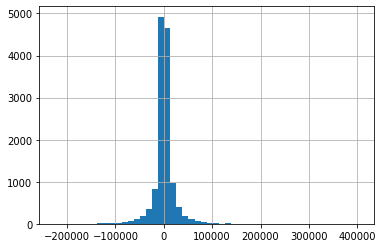

In [53]:
sorted_df['residuals'].hist(bins=50)

In [ ]:
from pdpbox import pdp

for col in x_train.columns:    
    # Create the data that we will plot
    pdp_goals = pdp.pdp_isolate(model=regressor, dataset=pd.DataFrame(x_train), model_features=x_train.columns, feature=col)

    # plot it
    pdp.pdp_plot(pdp_goals, col, figsize=(10,5))
    plt.show()

### Random Forest Model

In [ ]:
#Write a function that calculates mape
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Optimize the objective function with hyperopt for xgboost
#Definte the search spaces
space = {
        
            'min_impurity_split' : [None, 1, 2, 3, 4, 5, 6, 7, 8 , 9, 10],
            'max_features' : ['auto', 'sqrt', 'log2']
         }

#Objective function
def acc_model(params):
    
    depth = int(params['max_depth'])
    est= int(params['n_estimators'])
    max_nodes = int(params['max_leaf_nodes'])
    min_leaf = int(params['min_samples_leaf'])
    min_split = int(params['min_samples_split'])
   
    regressor = RandomForestRegressor(
                                      random_state=24,
                                      criterion='mae', 
                                      n_estimators= est, 
                                      max_depth=depth,
                                      max_features=params['max_features'],
                                      min_samples_split=min_split,
                                      min_samples_leaf = min_leaf,
                                      min_weight_fraction_leaf = params['min_weight_fraction_leaf'],
                                      max_leaf_nodes = max_nodes
                                      #min_impurity_decrease= params['min_impurity_decrease'],
                                      
                                      )
                                      
                                      
    regressor.fit(x_train, y_train)
    val_predictions = regressor.predict(x_val)**2
    y_val_transformed = y_val**2
    return mean_absolute_percentage_error(y_val_transformed, val_predictions)

#Define the search space
param_space = {
                'n_estimators': hp.quniform('n_estimators', 10,500,1),
                'max_depth': hp.quniform('max_depth',1,50,1),
                'max_features' : hp.choice('max_features', space.get('max_features')),
                'min_samples_split': hp.quniform('min_samples_split', 1,500,1),
                'min_samples_leaf': hp.uniform('min_samples_leaf',1,150),
                'min_weight_fraction_leaf': hp.uniform('min_weight_fraction_leaf',0,.5),
                'max_leaf_nodes': hp.quniform('max_leaf_nodes',1,1000,1),
                #'min_impurity_decrease': hp.uniform('min_impurity_decrease', 1,100),
                
            }

best = 1000

def f(params):
    global best
    acc = acc_model(params)
    if acc < best:
        best = acc
        print ('new best:', best, params) 
        
    return {'loss': acc, 'status': STATUS_OK}

trials = Trials()
best_params = fmin(f, param_space, algo=tpe.suggest, max_evals=25, trials=trials)
print ('best:')
print (best_params)

In [37]:
#Create a function that can transform the parameters into a readable object for the Random Forest Regressor
def return_proper_params(best):
    temp = best.copy()
    temp['max_depth'] = int(temp['max_depth'])
    temp['n_estimators'] = int(temp['n_estimators'])
    temp['min_samples_split'] = int(temp['min_samples_split'])
    temp['min_samples_leaf'] = int(temp['min_samples_leaf'])
    temp['max_leaf_nodes'] = int(temp['max_leaf_nodes'])
    #for param in space:
    
    #    temp[param] = space.get(param)[best.get(param)]
        
    return temp


best_params = return_proper_params(best_params)

In [43]:
#save_obj(best_params, 'best_params_random_forest')
best_params = load_obj('best_params_random_forest')
best_params

{'max_depth': 20,
 'max_features': 0,
 'max_leaf_nodes': 988,
 'min_samples_leaf': 88,
 'min_samples_split': 243,
 'min_weight_fraction_leaf': 0.01650516922957682,
 'n_estimators': 19}

In [49]:
#Write a function that calculates mape
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


regressor = RandomForestRegressor(
                                  random_state=24,
                                  criterion='mae', 
                                  n_estimators= int(best_params['n_estimators']), 
                                  max_depth= best_params['max_depth'],
                                  #max_features=best_params['max_features'],
                                  min_samples_split= best_params['min_samples_split'], 
                                  min_samples_leaf = int(best_params['min_samples_leaf']),
                                  min_weight_fraction_leaf = best_params['min_weight_fraction_leaf'],
                                  max_leaf_nodes = best_params['max_leaf_nodes']
                                  #min_impurity_decrease= best_params['min_impurity_decrease'],
                                 )

regressor.fit(x_train, y_train)

# Use this code when using the power transformer
# Need to back transform the target variable
test_predictions = regressor.predict(x_test)**2
y_test_transformed = y_test**2


score = np.round(mean_absolute_percentage_error(y_test_transformed, test_predictions),3)
print(f'Random Forest mape on testing set: {score}%')

Random Forest mape on testing set: 23.169%


In [50]:
#MAPE for the train set
train_predictions = regressor.predict(x_train)**2
y_train_transformed = y_train**2

score = np.round(mean_absolute_percentage_error(y_train_transformed, train_predictions),3)
print(f'Random Forest mape on training set: {score}%')

Random Forest mape on training set: 22.104%


In [52]:
#Let's examine the residuals
residuals = x_train.copy()
residuals['sale_price'] = y_train_transformed
residuals['predicted_sale_price'] = train_predictions
residuals['residuals'] = y_train_transformed - train_predictions
sorted_df = residuals.sort_values(by='residuals', ascending=False)
sorted_df

,HomeSize,LotSize,YearBuilt,Age,SexOffenders,EnviornmentalHazards,Bedrooms,Bathrooms,Neighborhood,distance_0,distance_1,distance_2,distance_3,distance_4,distance_5,distance_6,distance_7,distance_8,CrimeIndex_Slightly High,CrimeIndex_Low,CrimeIndex_Moderate,CrimeIndex_High,CrimeIndex_Very Low,CrimeIndex_Moderately High,CrimeIndex_Very High,SchoolQuality_Average,SchoolQuality_Above Average,SchoolQuality_Poor,SchoolQuality_Excellent,sale_price,predicted_sale_price,residuals
4647,1763.00000,6372.00000,1994,5,11,2,4,3,645.95685,0.65625,0.07123,0.67618,0.51766,0.56808,0.83678,0.83225,0.67828,0.74477,0,0,1,0,0,0,0,1,0,0,0,1628303.60250,351888.92502,1276414.67748
4646,1763.00000,6372.00000,1994,5,11,2,4,3,645.95685,0.65625,0.07123,0.67618,0.51766,0.56808,0.83678,0.83225,0.67828,0.74477,0,0,1,0,0,0,0,1,0,0,0,1628303.60250,351888.92502,1276414.67748
4649,1763.00000,6372.00000,1994,5,11,2,4,3,645.95685,0.65625,0.07123,0.67618,0.51766,0.56808,0.83678,0.83225,0.67828,0.74477,0,0,1,0,0,0,0,1,0,0,0,1628303.60250,351888.92502,1276414.67748
3964,1135.00000,5697.00000,1993,16,4,3,3,2,645.95685,0.64959,0.07169,0.72841,0.47875,0.58347,0.85810,0.83712,0.71198,0.71067,0,0,1,0,0,0,0,0,0,1,0,1563500.16000,312464.25965,1251035.90035
3968,1135.00000,5697.00000,1993,16,4,3,3,2,645.95685,0.64959,0.07169,0.72841,0.47875,0.58347,0.85810,0.83712,0.71198,0.71067,0,0,1,0,0,0,0,0,0,1,0,1563500.16000,312464.25965,1251035.90035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14550,3327.00000,14858.00000,1962,58,0,3,4,4,1034.03233,0.34248,0.92385,0.65698,0.61689,0.43244,0.27689,0.15609,0.46091,0.47496,0,0,0,0,1,0,0,0,0,0,1,199825.09232,1215062.96937,-1015237.87705
435,2795.00000,8070.00000,1965,55,0,3,4,3,999.22954,0.35012,0.76098,0.89923,0.31553,0.53665,0.64575,0.47204,0.71120,0.09643,0,0,0,0,1,0,0,0,1,0,0,113766.56785,1165805.28004,-1052038.71219
7391,3124.00000,7500.00000,1914,76,5,11,4,1,1020.17241,0.06904,0.60842,0.49151,0.35512,0.14926,0.26758,0.16914,0.29801,0.33280,1,0,0,0,0,0,0,0,1,0,0,137260.61717,1192899.11547,-1055638.49831
7392,3124.00000,7500.00000,1914,76,5,11,4,1,1020.17241,0.06904,0.60842,0.49151,0.35512,0.14926,0.26758,0.16914,0.29801,0.33280,1,0,0,0,0,0,0,0,1,0,0,137260.61717,1192899.11547,-1055638.49831
